# Genre Fix

This dataset has too many genres, they are too granular. The aim of this notebook:
1. Split problematic genres, those with "joint" genres, e.g. "Science and Drama".
2. Normalize genres to common names.
3. Combine genres until there are 10 main ones.

## Import data

In [1]:
import os
import sys
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

notebook_dir = Path().resolve()
base_path = os.path.abspath(notebook_dir.parent.parent)
sys.path.append(base_path)
from src.data_utils import *

In [2]:
embeddings, movie_ids  = load_movie_embeddings(os.path.join(base_path, "data", "data_final"))

In [3]:
embeddings.shape

(161553, 1024)

In [4]:
movie_ids.shape

(161553,)

In [5]:
movie_df = load_movie_data(os.path.join(base_path, "data", "data_final"))

In [6]:
movie_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 213903 entries, 0 to 213902
Data columns (total 22 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   movie_id        213903 non-null  object
 1   title           213903 non-null  object
 2   summary         0 non-null       object
 3   release_date    213903 non-null  object
 4   genre           176075 non-null  object
 5   director        190332 non-null  object
 6   actors          145306 non-null  object
 7   duration        131113 non-null  object
 8   imdb_id         201370 non-null  object
 9   country         204335 non-null  object
 10  sitelinks       213903 non-null  object
 11  wikipedia_link  213903 non-null  object
 12  budget          8609 non-null    object
 13  box_office      7786 non-null    object
 14  awards          9830 non-null    object
 15  set_in_period   3500 non-null    object
 16  year            213903 non-null  int64 
 17  popularity      181485 non-nu

In [7]:
movie_df[movie_df.year==1950].shape

(1523, 22)

## Genre exploration

In [8]:
all_genres = movie_df[movie_df.genre.notna()].genre.unique()

In [9]:
all_genres

array(['musical, fantasy film, melodrama, musical film, romance film, family film, cinematic fairy tale',
       'drama film, comedy film, film based on literature',
       'drama film, samurai cinema, crime film, medieval film, flashback film',
       ..., 'fantasy drama',
       'documentary film, prison film, musical film, LGBT-related film',
       'thriller film, time-travel film'], shape=(13188,), dtype=object)

In [10]:
# Sample randomly and see examples of genres
import random

print(random.choice(all_genres))
print(random.choice(all_genres))
print(random.choice(all_genres))
print(random.choice(all_genres))
print(random.choice(all_genres))

dance-pop, pop rock, Latin pop
drama film, swashbuckler film, romantic comedy
drama film, action film, thriller film, survival film
romance, romance film
drama film, crime film, thriller film, social film


In [11]:
random.choice(all_genres[np.array(["and" in i for i in all_genres])])

'historical anime and manga'

It seems like the common delimeters are commas and "and". Splitting by these should give us all possible genres, however there weirder ones like "film from a novel". 

In [36]:
# First split by "," and "and"
import re

def split_all_genres(genre: str):
    split_genres = genre.split(",")
    split_genres = list(set([i.lower().replace("film", "").strip() for i in split_genres]))
    return "|".join(split_genres)

new_genres = []
for row in all_genres:
    split_genres = row.split(",")
    split_genres = [i.lower().replace("film", "").strip() for i in split_genres]
    new_genres.extend(split_genres)

In [42]:
non_null_genres = movie_df[movie_df.genre.notna()].reset_index(drop=True)

In [43]:
non_null_genres["genre_cleaned"] = non_null_genres["genre"].apply(split_all_genres)

In [13]:
from collections import Counter

In [14]:
genre_counter = Counter(new_genres)

In [15]:
len(genre_counter)

975

In [17]:
genre_counter.most_common(10)

[('drama', 4274),
 ('action', 2416),
 ('comedy', 2388),
 ('thriller', 1783),
 ('science fiction', 1655),
 ('horror', 1632),
 ('fantasy', 1623),
 ('adventure', 1619),
 ('crime', 1394),
 ('romance', 1073)]

Check how many movies will be lost if we drop movies out of top 10

In [39]:
def genre_in_top_10(genre_cleaned: str, top_10: list[str]) -> bool:
    for genre in top_10:
        if genre in genre_cleaned:
            return True
        
    return False

In [51]:
top_10_genres = [i[0] for i in genre_counter.most_common(20)]

In [52]:
non_null_genres["genre_in_top_10"] = non_null_genres["genre_cleaned"].apply(lambda x: genre_in_top_10(x, top_10_genres))

In [53]:
non_null_genres[~non_null_genres.genre_in_top_10].shape

(33459, 24)

In [54]:
non_null_genres.shape

(176075, 24)

Use sentence transformers to embed genres and cluster them.

In [17]:
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans

In [18]:
model = SentenceTransformer('all-MiniLM-L6-v2')

In [19]:
genre_embeddings = model.encode(new_genres)

In [20]:
genre_embeddings.shape

(47655, 384)

In [21]:
# Clustering
n_clusters = 10
kmeans = KMeans(n_clusters=n_clusters, random_state=123)
labels = kmeans.fit_predict(genre_embeddings)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
/Users/nselcheung/opt/anaconda3/envs/data_literacy/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/nselcheung/opt/anaconda3/envs/data_literacy/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/nselcheung/opt/anaconda3/envs/data_literacy/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/nselcheung/opt/anaconda3/envs/data_literacy/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: divide by zero encounter

In [22]:
genre_clusters = pd.DataFrame({"genre": new_genres, "cluster": labels})

In [23]:
genre_clusters[genre_clusters.cluster==9].genre.unique()

array(['noir', 'thriller', 'suspense', 'crime thriller',
       'political thriller', 'horror', 'psychological thriller', 'ghost',
       'comedy thriller', 'romantic thriller', 'vampire', 'zombie',
       'supernatural horror', 'science fiction horror', 'horror fiction',
       'psychological horror', 'natural horror', 'neo-noir',
       'action thriller', 'erotic thriller', 'midnight movie',
       'animal horror', 'supernatural', 'horror western', 'body horror',
       'horror fantasy', 'gothic horror', 'thriller anime',
       'erotic horror', 'list of holiday horror s',
       'horror anime and manga', 'thriller television series',
       'horror television series', 'techno-thriller', 'legal thriller',
       'body horror television program', 'lovecraftian horror',
       'japanese horror', 'medical thriller', 'horrorcore', 'halloween',
       'horror literature', 'cosmic horror', 'teen horror',
       'financial thriller', 'paranormal fiction', 'folk horror',
       'thriller pla

10 Main clusters:
* cluster 0: Others
* cluster 1: Comedy
* cluster 2: Romance
* cluster 3: Drama
* cluster 4: Fantasy
* cluster 5: Action
* cluster 6: Science Fiction
* cluster 7: Family
* cluster 8: Mystery
* cluster 9: Thriller

In [24]:
cluster_label_mapping = {
    0: "others",
    1: "comedy",
    2: "romance",
    3: "drama",
    4: "fantasy",
    5: "action",
    6: "scifi",
    7: "family",
    8: "mystery",
    9: "thriller"
}

In [25]:
genre_clusters["new_label"] = genre_clusters["cluster"].apply(lambda x: cluster_label_mapping[x])

In [30]:
movie_df.genre

0         musical, fantasy film, melodrama, musical film...
1         drama film, comedy film, film based on literature
2         drama film, samurai cinema, crime film, mediev...
3         drama film, film noir, adventure film, mystery...
4                     drama film, film noir, flashback film
                                ...                        
213898                                          comedy film
213899                                    biographical film
213900                                     documentary film
213901                                                  NaN
213902                                          action film
Name: genre, Length: 213903, dtype: object

In [28]:
for genre in cluster_label_mapping.values():
    print(f"Genre - {genre.upper()}")
    original_genres = genre_clusters[genre_clusters.new_label == genre].genre.unique()
    for i, original_g in enumerate(original_genres):
        print(f"    - {original_g}")

Genre - OTHERS
    - melodrama
    - cinematic fairy tale
    - samurai cinema
    - medieval
    - flashback
    - heist
    - gangster
    - western
    - auteur
    - sword-and-sandal
    - disaster
    - propaganda
    - swashbuckler
    - slapstick
    - art
    - revisionist western
    - boxing
    - pirate
    - silent
    - experimental
    - documentary
    - trial
    - post-apocalyptic
    - nature documentary
    - historical
    - animated
    - anthology
    - heimat
    - american football
    - epic
    - puppet
    - fairy tale
    - association football
    - docudrama
    - slice of life
    - rumberas
    - telenovela
    - operetta
    - educational
    - semidocumentary
    - short
    - exploitation
    - neorealism
    - animated cartoon
    - coming-of-age
    - monster
    - staliniana
    - superhero
    - buddy
    - adaptation
    - mumbai noir
    - political
    - live-action/animated
    - athletics
    - dance
    - spaghetti western
    - women in pri

In [41]:
# Generate json file for genre to cluster mapping
map_df = genre_clusters.drop_duplicates("genre").drop(columns=["cluster"])
mapping_dict = {}
for i, row in map_df.iterrows():
    mapping_dict[row["genre"]] = row["new_label"]

In [44]:
len(mapping_dict)

975

In [47]:
import json

In [49]:
with open("../genre_fix_mapping.json", "w") as f:
    f.write(json.dumps(mapping_dict))

In [52]:
with open("../genre_fix_mapping.json", "r") as f:
    test = json.loads(f.read())

In [54]:
test["musical"]

'comedy'

Seems to work fine (some pretty weird labelling e.g. War movies in Family genre.).

Suggestion was to try genre clustering using more context, such as scraping the wikipedia entries for each genre.

## Genre clustering using wiki entries

In [1]:
import os
import sys
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

notebook_dir = Path().resolve()
base_path = os.path.abspath(notebook_dir.parent.parent)
sys.path.append(base_path)
from src.data_utils import *
from src.api.wikipedia_handler import get_page_from_url

In [2]:
movie_df = load_movie_data(os.path.join(base_path, "data", "data_20251125"))

In [3]:
movie_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 141119 entries, 0 to 141118
Data columns (total 30 columns):
 #   Column                         Non-Null Count   Dtype 
---  ------                         --------------   ----- 
 0   movie_id                       141119 non-null  object
 1   country                        138264 non-null  object
 2   imdb_id                        137125 non-null  object
 3   duration                       79499 non-null   object
 4   duration_all                   79499 non-null   object
 5   actors_id                      108527 non-null  object
 6   actors                         108527 non-null  object
 7   directors_id                   128578 non-null  object
 8   directors                      128578 non-null  object
 9   genre_id                       118524 non-null  object
 10  genre                          118524 non-null  object
 11  release_date                   141119 non-null  object
 12  wikidata_class                 141119 non-nu

In [100]:
rand_row = movie_df.sample(1).iloc[0]
print(rand_row.genre_id)
print(rand_row.genre)

Q130232,Q860626,Q1054574,Q20442589
drama film, romantic comedy, romance film, LGBT-related film


In [97]:
movie_df["genre_wiki_id_len"] = movie_df["genre_id"].apply(lambda x: len(x.split(",")) if isinstance(x, str) else 0)

In [83]:
movie_df.genre_wiki_id_len.max()

np.int64(25)

In [108]:
import requests
import wikipediaapi

def get_wikipedia_title_from_wikiid(genre_id: str) -> str | None:
    try:
        media_wiki_url = "https://www.wikidata.org/w/api.php?action=wbgetentities&format=json&languages=en&sitefilter=enwiki&ids={wikiid}"
        user_agent = 'GroupDataLiteracy/1.0 (movie data pipeline)'

        mediawiki_response = requests.get(media_wiki_url.format(wikiid=genre_id), headers={"User-Agent": user_agent})

        json_response = mediawiki_response.json()

        genre_wikipedia_title = json_response["entities"][list(json_response["entities"].keys())[0]]["sitelinks"]["enwiki"]["title"]

        return genre_wikipedia_title
    except Exception as e:
        print(f"Unable to get wikipedia Title of genre_id: {genre_id}, error: {e}")
        return None

user_agent = 'GroupDataLiteracy/1.0 (movie data pipeline)'
wiki_wiki = wikipediaapi.Wikipedia(
        user_agent=user_agent,
        language='en'
    )

def get_wikipedia_description_from_title(genre_title: str, wiki_wiki) -> str:
    try:
        genre_page = get_page_from_url(wiki_wiki, f"https://en.wikipedia.org/wiki/{genre_title.lower().replace(' ', '_')}")
        if genre_page is None or not genre_page.exists():
            return ""
        return genre_page.summary
    except Exception as e:
        print(f"Error fetching genre {genre}: {e}")
        return ""

In [103]:
raw_genres = movie_df[movie_df.genre.notna()].genre.unique()

In [104]:
# Split genres by comma and strip whitespace
split_genres = []
for genre in raw_genres:
    parts = genre.split(",")
    parts = [part.strip() for part in parts]
    split_genres.extend(parts)

In [105]:
unique_genres = list(set(split_genres))

In [106]:
len(unique_genres)

865

In [110]:
from tqdm import tqdm

In [111]:
# Get all wikipedia descriptions of unique genres
user_agent = 'GroupDataLiteracy/1.0 (movie data pipeline)'
wiki_wiki = wikipediaapi.Wikipedia(
        user_agent=user_agent,
        language='en'
    )

genre_descriptions = {}
for genre in tqdm(unique_genres, total=len(unique_genres), desc="Fetching genre descriptions"):
    description = get_wikipedia_description_from_title(genre, wiki_wiki)
    genre_descriptions[genre] = description

Fetching genre descriptions:   1%|          | 6/865 [00:02<04:24,  3.25it/s]

Error fetching genre novella film: Wikipedia page not found: novella film


Fetching genre descriptions:   1%|          | 9/865 [00:03<04:16,  3.34it/s]

Error fetching genre biographical sports film: Wikipedia page not found: biographical sports film


Fetching genre descriptions:   2%|▏         | 21/865 [00:08<04:54,  2.87it/s]

Error fetching genre LGBT-related television series: Wikipedia page not found: lgbt-related television series


Fetching genre descriptions:   3%|▎         | 23/865 [00:08<04:08,  3.39it/s]

Error fetching genre love triangle romance: Wikipedia page not found: love triangle romance


Fetching genre descriptions:   3%|▎         | 27/865 [00:10<04:41,  2.97it/s]

Error fetching genre stop-motion animated film: Wikipedia page not found: stop-motion animated film


Fetching genre descriptions:   5%|▍         | 39/865 [00:14<04:23,  3.13it/s]

Error fetching genre gay-related film: Wikipedia page not found: gay-related film
Error fetching genre political magazine show: Wikipedia page not found: political magazine show


Fetching genre descriptions:   5%|▌         | 46/865 [00:17<04:53,  2.79it/s]

Error fetching genre xiaoshuo: Wikipedia page not found: xiaoshuo


Fetching genre descriptions:   6%|▌         | 48/865 [00:17<04:33,  2.98it/s]

Error fetching genre pritcha: Wikipedia page not found: pritcha


Fetching genre descriptions:   6%|▌         | 50/865 [00:18<04:30,  3.01it/s]

Error fetching genre knight film: Wikipedia page not found: knight film


Fetching genre descriptions:   6%|▌         | 52/865 [00:19<04:18,  3.15it/s]

Error fetching genre crime documentary: Wikipedia page not found: crime documentary


Fetching genre descriptions:   6%|▋         | 55/865 [00:20<04:48,  2.80it/s]

Error fetching genre backwoods film: Wikipedia page not found: backwoods film


Fetching genre descriptions:   7%|▋         | 57/865 [00:21<04:47,  2.81it/s]

Error fetching genre coming-of-age fiction: Wikipedia page not found: coming-of-age fiction


Fetching genre descriptions:   7%|▋         | 60/865 [00:22<04:23,  3.06it/s]

Error fetching genre fustanella film: Wikipedia page not found: fustanella film


Fetching genre descriptions:   8%|▊         | 65/865 [00:24<05:19,  2.50it/s]

Error fetching genre comedy drama anime and manga: Wikipedia page not found: comedy drama anime and manga


Fetching genre descriptions:   8%|▊         | 71/865 [00:26<03:56,  3.35it/s]

Error fetching genre school anime and manga: Wikipedia page not found: school anime and manga
Error fetching genre war comedy film: Wikipedia page not found: war comedy film


Fetching genre descriptions:  10%|▉         | 83/865 [00:31<04:35,  2.84it/s]

Error fetching genre adventure science fiction: Wikipedia page not found: adventure science fiction


Fetching genre descriptions:  10%|▉         | 86/865 [00:32<03:44,  3.46it/s]

Error fetching genre behind-the-scenes film: Wikipedia page not found: behind-the-scenes film


Fetching genre descriptions:  11%|█         | 91/865 [00:34<04:33,  2.83it/s]

Error fetching genre Halloween film: Wikipedia page not found: halloween film


Fetching genre descriptions:  11%|█         | 94/865 [00:36<06:17,  2.04it/s]

Error fetching genre gambling film: Wikipedia page not found: gambling film


Fetching genre descriptions:  11%|█         | 96/865 [00:36<04:38,  2.76it/s]

Error fetching genre film installation: Wikipedia page not found: film installation


Fetching genre descriptions:  11%|█▏        | 99/865 [00:37<03:30,  3.64it/s]

Error fetching genre romantic drama fiction: Wikipedia page not found: romantic drama fiction
Error fetching genre television series based on a novel: Wikipedia page not found: television series based on a novel


Fetching genre descriptions:  12%|█▏        | 106/865 [00:40<04:33,  2.77it/s]

Error fetching genre autobiographical film: Wikipedia page not found: autobiographical film


Fetching genre descriptions:  13%|█▎        | 110/865 [00:42<04:08,  3.03it/s]

Error fetching genre Horror based on children's characters: Wikipedia page not found: horror based on children's characters


Fetching genre descriptions:  13%|█▎        | 113/865 [00:43<04:05,  3.06it/s]

Error fetching genre spoken drama: Wikipedia page not found: spoken drama


Fetching genre descriptions:  14%|█▎        | 117/865 [00:44<03:04,  4.05it/s]

Error fetching genre time-travel film: Wikipedia page not found: time-travel film
Error fetching genre ballet film: Wikipedia page not found: ballet film


Fetching genre descriptions:  14%|█▍        | 125/865 [00:47<04:31,  2.73it/s]

Error fetching genre action anime and manga: Wikipedia page not found: action anime and manga


Fetching genre descriptions:  15%|█▍        | 129/865 [00:49<03:53,  3.15it/s]

Error fetching genre Ozploitation film: Wikipedia page not found: ozploitation film


Fetching genre descriptions:  15%|█▌        | 132/865 [00:50<03:29,  3.49it/s]

Error fetching genre popular science film: Wikipedia page not found: popular science film


Fetching genre descriptions:  16%|█▌        | 136/865 [00:51<03:28,  3.49it/s]

Error fetching genre comedy porn film: Wikipedia page not found: comedy porn film


Fetching genre descriptions:  16%|█▌        | 139/865 [00:52<03:21,  3.61it/s]

Error fetching genre BDSM-themed film: Wikipedia page not found: bdsm-themed film


Fetching genre descriptions:  17%|█▋        | 146/865 [00:55<04:03,  2.96it/s]

Error fetching genre LGBT-related film: Wikipedia page not found: lgbt-related film


Fetching genre descriptions:  17%|█▋        | 149/865 [00:56<04:13,  2.83it/s]

Error fetching genre rural drama: Wikipedia page not found: rural drama


Fetching genre descriptions:  18%|█▊        | 155/865 [00:58<04:47,  2.47it/s]

Error fetching genre action anime: Wikipedia page not found: action anime


Fetching genre descriptions:  20%|██        | 175/865 [01:12<05:41,  2.02it/s]

Error fetching genre association football film: Wikipedia page not found: association football film


Fetching genre descriptions:  23%|██▎       | 196/865 [01:20<03:43,  2.99it/s]

Error fetching genre space drama: Wikipedia page not found: space drama


Fetching genre descriptions:  23%|██▎       | 201/865 [01:22<03:34,  3.09it/s]

Error fetching genre detective television series: Wikipedia page not found: detective television series


Fetching genre descriptions:  24%|██▍       | 206/865 [01:24<03:08,  3.50it/s]

Error fetching genre American football film: Wikipedia page not found: american football film
Error fetching genre comical satyre: Wikipedia page not found: comical satyre


Fetching genre descriptions:  24%|██▍       | 210/865 [01:25<03:18,  3.30it/s]

Error fetching genre film based on book: Wikipedia page not found: film based on book
Error fetching genre Sherlock Holmes television program: Wikipedia page not found: sherlock holmes television program


Fetching genre descriptions:  24%|██▍       | 211/865 [01:25<02:55,  3.74it/s]

Error fetching genre student film: Wikipedia page not found: student film


Fetching genre descriptions:  25%|██▍       | 215/865 [01:27<03:18,  3.27it/s]

Error fetching genre CMC Pictures: Wikipedia page not found: cmc pictures


Fetching genre descriptions:  25%|██▌       | 220/865 [01:29<03:28,  3.10it/s]

Error fetching genre Neue Deutsche Härte: Wikipedia page not found: neue deutsche härte
Error fetching genre bushranging film: Wikipedia page not found: bushranging film


Fetching genre descriptions:  26%|██▌       | 224/865 [01:30<03:17,  3.24it/s]

Error fetching genre cinematic fairy tale: Wikipedia page not found: cinematic fairy tale


Fetching genre descriptions:  26%|██▌       | 226/865 [01:31<03:46,  2.82it/s]

Error fetching genre holiday-themed film: Wikipedia page not found: holiday-themed film


Fetching genre descriptions:  27%|██▋       | 231/865 [01:33<03:34,  2.95it/s]

Error fetching genre animated film with LGBT character(s): Wikipedia page not found: animated film with lgbt character(s)


Fetching genre descriptions:  27%|██▋       | 235/865 [01:34<02:56,  3.56it/s]

Error fetching genre vampire television program: Wikipedia page not found: vampire television program
Error fetching genre ice hockey film: Wikipedia page not found: ice hockey film


Fetching genre descriptions:  28%|██▊       | 244/865 [01:38<03:23,  3.06it/s]

Error fetching genre historical documentary film: Wikipedia page not found: historical documentary film


Fetching genre descriptions:  30%|██▉       | 258/865 [01:43<03:05,  3.28it/s]

Error fetching genre Sámi film: Wikipedia page not found: sámi film


Fetching genre descriptions:  30%|███       | 260/865 [01:44<02:47,  3.60it/s]

Error fetching genre Landismo: Wikipedia page not found: landismo


Fetching genre descriptions:  31%|███       | 266/865 [01:46<03:02,  3.29it/s]

Error fetching genre post-apocalyptic video game: Wikipedia page not found: post-apocalyptic video game


Fetching genre descriptions:  32%|███▏      | 273/865 [01:49<02:55,  3.37it/s]

Error fetching genre gag anime: Wikipedia page not found: gag anime


Fetching genre descriptions:  32%|███▏      | 276/865 [01:50<02:53,  3.40it/s]

Error fetching genre production cinema: Wikipedia page not found: production cinema


Fetching genre descriptions:  32%|███▏      | 278/865 [01:50<02:39,  3.69it/s]

Error fetching genre erotic drama film: Wikipedia page not found: erotic drama film


Fetching genre descriptions:  34%|███▎      | 290/865 [01:55<02:59,  3.20it/s]

Error fetching genre youth series: Wikipedia page not found: youth series


Fetching genre descriptions:  34%|███▍      | 294/865 [01:56<03:35,  2.64it/s]

Error fetching genre folk horror film: Wikipedia page not found: folk horror film


Fetching genre descriptions:  36%|███▌      | 310/865 [02:03<03:07,  2.96it/s]

Error fetching genre supernatural anime: Wikipedia page not found: supernatural anime


Fetching genre descriptions:  37%|███▋      | 316/865 [02:07<05:00,  1.83it/s]

Error fetching genre mature film: Wikipedia page not found: mature film


Fetching genre descriptions:  37%|███▋      | 318/865 [02:07<03:56,  2.31it/s]

Error fetching genre Holocaust in the movies: Wikipedia page not found: holocaust in the movies


Fetching genre descriptions:  37%|███▋      | 322/865 [02:09<03:11,  2.83it/s]

Error fetching genre children and youth program: Wikipedia page not found: children and youth program


Fetching genre descriptions:  38%|███▊      | 325/865 [02:10<02:42,  3.32it/s]

Error fetching genre comedy television program: Wikipedia page not found: comedy television program


Fetching genre descriptions:  39%|███▊      | 334/865 [02:13<02:40,  3.31it/s]

Error fetching genre post-apocalyptic anime: Wikipedia page not found: post-apocalyptic anime


Fetching genre descriptions:  39%|███▉      | 338/865 [02:14<02:46,  3.17it/s]

Error fetching genre transgender film: Wikipedia page not found: transgender film


Fetching genre descriptions:  40%|████      | 348/865 [02:18<03:12,  2.69it/s]

Error fetching genre body horror television program: Wikipedia page not found: body horror television program


Fetching genre descriptions:  41%|████▏     | 357/865 [02:24<06:34,  1.29it/s]

Error fetching genre circus film: Wikipedia page not found: circus film


Fetching genre descriptions:  42%|████▏     | 359/865 [02:25<04:18,  1.95it/s]

Error fetching genre Manchurian Western: Wikipedia page not found: manchurian western


Fetching genre descriptions:  42%|████▏     | 363/865 [02:26<02:47,  2.99it/s]

Error fetching genre adventure television series: Wikipedia page not found: adventure television series


Fetching genre descriptions:  44%|████▎     | 377/865 [02:32<02:56,  2.76it/s]

Error fetching genre women's association football film: Wikipedia page not found: women's association football film
Error fetching genre horror fantasy film: Wikipedia page not found: horror fantasy film


Fetching genre descriptions:  44%|████▍     | 382/865 [02:34<02:57,  2.72it/s]

Error fetching genre Romanian historical film: Wikipedia page not found: romanian historical film


Fetching genre descriptions:  45%|████▌     | 390/865 [02:38<03:12,  2.47it/s]

Error fetching genre fantasy video game: Wikipedia page not found: fantasy video game


Fetching genre descriptions:  45%|████▌     | 392/865 [02:39<02:30,  3.13it/s]

Error fetching genre espionage television series: Wikipedia page not found: espionage television series


Fetching genre descriptions:  46%|████▌     | 397/865 [02:40<02:21,  3.31it/s]

Error fetching genre comedy anime and manga: Wikipedia page not found: comedy anime and manga
Error fetching genre spokon: Wikipedia page not found: spokon


Fetching genre descriptions:  46%|████▌     | 398/865 [02:41<02:03,  3.78it/s]

Error fetching genre sports documentary: Wikipedia page not found: sports documentary


Fetching genre descriptions:  46%|████▋     | 401/865 [02:42<02:02,  3.80it/s]

Error fetching genre classical antiquity film: Wikipedia page not found: classical antiquity film
Error fetching genre werewolf television program: Wikipedia page not found: werewolf television program


Fetching genre descriptions:  47%|████▋     | 405/865 [02:45<03:28,  2.21it/s]

Error fetching genre Q20107852: Wikipedia page not found: q20107852
Error fetching genre steampunk film: Wikipedia page not found: steampunk film


Fetching genre descriptions:  47%|████▋     | 406/865 [02:45<02:47,  2.74it/s]

Error fetching genre coming-of-age drama: Wikipedia page not found: coming-of-age drama


Fetching genre descriptions:  48%|████▊     | 413/865 [02:48<02:27,  3.06it/s]

Error fetching genre blaxploitation horror film: Wikipedia page not found: blaxploitation horror film


Fetching genre descriptions:  49%|████▊     | 420/865 [02:51<03:21,  2.20it/s]

Error fetching genre grotesque film: Wikipedia page not found: grotesque film


Fetching genre descriptions:  49%|████▉     | 428/865 [02:55<02:40,  2.73it/s]

Error fetching genre proletarian film: Wikipedia page not found: proletarian film


Fetching genre descriptions:  50%|████▉     | 431/865 [02:56<01:51,  3.88it/s]

Error fetching genre fantasy television series: Wikipedia page not found: fantasy television series
Error fetching genre chase film: Wikipedia page not found: chase film


Fetching genre descriptions:  51%|█████▏    | 445/865 [03:01<02:13,  3.14it/s]

Error fetching genre science fiction television program: Wikipedia page not found: science fiction television program


Fetching genre descriptions:  52%|█████▏    | 454/865 [03:04<02:08,  3.19it/s]

Error fetching genre romance television series: Wikipedia page not found: romance television series


Fetching genre descriptions:  53%|█████▎    | 455/865 [03:05<02:10,  3.14it/s]

Error fetching genre extraterrestrial film: Wikipedia page not found: extraterrestrial film


Fetching genre descriptions:  53%|█████▎    | 458/865 [03:06<02:00,  3.38it/s]

Error fetching genre Q12962776: Wikipedia page not found: q12962776


Fetching genre descriptions:  54%|█████▎    | 463/865 [03:08<02:13,  3.01it/s]

Error fetching genre abstract animation film: Wikipedia page not found: abstract animation film


Fetching genre descriptions:  54%|█████▍    | 467/865 [03:09<02:11,  3.04it/s]

Error fetching genre coming-of-age anime and manga: Wikipedia page not found: coming-of-age anime and manga


Fetching genre descriptions:  54%|█████▍    | 469/865 [03:10<01:58,  3.36it/s]

Error fetching genre animated television film: Wikipedia page not found: animated television film


Fetching genre descriptions:  54%|█████▍    | 471/865 [03:10<02:00,  3.27it/s]

Error fetching genre teen drama television: Wikipedia page not found: teen drama television


Fetching genre descriptions:  55%|█████▍    | 473/865 [03:11<01:48,  3.62it/s]

Error fetching genre animals documentary: Wikipedia page not found: animals documentary


Fetching genre descriptions:  55%|█████▍    | 475/865 [03:12<01:58,  3.30it/s]

Error fetching genre lesbian-related film: Wikipedia page not found: lesbian-related film


Fetching genre descriptions:  56%|█████▌    | 481/865 [03:16<04:40,  1.37it/s]

Error fetching genre family television series: Wikipedia page not found: family television series


Fetching genre descriptions:  56%|█████▌    | 482/865 [03:17<04:16,  1.49it/s]

Error fetching genre fantastique film: Wikipedia page not found: fantastique film


Fetching genre descriptions:  56%|█████▌    | 483/865 [03:17<03:58,  1.60it/s]

Error fetching genre horror anime and manga: Wikipedia page not found: horror anime and manga


Fetching genre descriptions:  56%|█████▌    | 486/865 [03:19<03:49,  1.65it/s]

Error fetching genre animal horror film: Wikipedia page not found: animal horror film


Fetching genre descriptions:  56%|█████▋    | 488/865 [03:21<03:18,  1.90it/s]

Error fetching genre post-apocalyptic anime and manga: Wikipedia page not found: post-apocalyptic anime and manga


Fetching genre descriptions:  58%|█████▊    | 498/865 [03:25<02:19,  2.63it/s]

Error fetching genre drama fiction: Wikipedia page not found: drama fiction


Fetching genre descriptions:  58%|█████▊    | 499/865 [03:25<02:02,  3.00it/s]

Error fetching genre romantic comedy anime and manga: Wikipedia page not found: romantic comedy anime and manga


Fetching genre descriptions:  59%|█████▉    | 510/865 [03:29<01:43,  3.44it/s]

Error fetching genre aqua-musical: Wikipedia page not found: aqua-musical
Error fetching genre triathlon films: Wikipedia page not found: triathlon films


Fetching genre descriptions:  59%|█████▉    | 513/865 [03:30<01:37,  3.61it/s]

Error fetching genre music-themed film: Wikipedia page not found: music-themed film
Error fetching genre science fiction animation: Wikipedia page not found: science fiction animation


Fetching genre descriptions:  59%|█████▉    | 514/865 [03:30<01:29,  3.93it/s]

Error fetching genre intersex film: Wikipedia page not found: intersex film


Fetching genre descriptions:  60%|█████▉    | 517/865 [03:31<01:35,  3.65it/s]

Error fetching genre teen horror film: Wikipedia page not found: teen horror film


Fetching genre descriptions:  60%|██████    | 520/865 [03:32<01:33,  3.70it/s]

Error fetching genre huis-clos film: Wikipedia page not found: huis-clos film


Fetching genre descriptions:  61%|██████    | 524/865 [03:34<01:54,  2.99it/s]

Error fetching genre film based on literature: Wikipedia page not found: film based on literature
Error fetching genre moral film: Wikipedia page not found: moral film


Fetching genre descriptions:  61%|██████    | 526/865 [03:35<01:41,  3.33it/s]

Error fetching genre sword-and-sandal film: Wikipedia page not found: sword-and-sandal film


Fetching genre descriptions:  62%|██████▏   | 536/865 [03:40<02:20,  2.35it/s]

Error fetching genre contemporary Western film: Wikipedia page not found: contemporary western film


Fetching genre descriptions:  63%|██████▎   | 541/865 [03:41<02:04,  2.60it/s]

Error fetching genre spy comedy film: Wikipedia page not found: spy comedy film


Fetching genre descriptions:  63%|██████▎   | 545/865 [03:44<02:30,  2.13it/s]

Error fetching genre bullfighting film: Wikipedia page not found: bullfighting film


Fetching genre descriptions:  63%|██████▎   | 547/865 [03:44<01:43,  3.09it/s]

Error fetching genre alternate history film: Wikipedia page not found: alternate history film
Error fetching genre thriller television series: Wikipedia page not found: thriller television series


Fetching genre descriptions:  64%|██████▎   | 550/865 [03:45<01:32,  3.42it/s]

Error fetching genre historical prose literature: Wikipedia page not found: historical prose literature


Fetching genre descriptions:  65%|██████▍   | 558/865 [03:49<01:56,  2.64it/s]

Error fetching genre thriller anime: Wikipedia page not found: thriller anime


Fetching genre descriptions:  65%|██████▍   | 562/865 [03:50<02:01,  2.50it/s]

Error fetching genre satirical film or television program: Wikipedia page not found: satirical film or television program


Fetching genre descriptions:  65%|██████▌   | 564/865 [03:51<02:01,  2.47it/s]

Error fetching genre romance television program: Wikipedia page not found: romance television program


Fetching genre descriptions:  66%|██████▌   | 568/865 [03:53<01:48,  2.74it/s]

Error fetching genre film performance: Wikipedia page not found: film performance


Fetching genre descriptions:  66%|██████▌   | 570/865 [03:54<01:42,  2.88it/s]

Error fetching genre culture clash comedy: Wikipedia page not found: culture clash comedy


Fetching genre descriptions:  66%|██████▌   | 573/865 [03:55<02:05,  2.32it/s]

Error fetching genre romance anime and manga: Wikipedia page not found: romance anime and manga


Fetching genre descriptions:  67%|██████▋   | 577/865 [03:57<01:49,  2.62it/s]

Error fetching genre contemporary R&B: Wikipedia page not found: contemporary r&b


Fetching genre descriptions:  67%|██████▋   | 581/865 [03:58<01:42,  2.77it/s]

Error fetching genre Schlagerfilm: Wikipedia page not found: schlagerfilm


Fetching genre descriptions:  68%|██████▊   | 585/865 [04:00<01:31,  3.07it/s]

Error fetching genre Bible film: Wikipedia page not found: bible film


Fetching genre descriptions:  68%|██████▊   | 588/865 [04:01<01:29,  3.08it/s]

Error fetching genre biographical television program: Wikipedia page not found: biographical television program


Fetching genre descriptions:  69%|██████▉   | 598/865 [04:05<01:24,  3.17it/s]

Error fetching genre eskrima film: Wikipedia page not found: eskrima film
Error fetching genre traditionally animated film: Wikipedia page not found: traditionally animated film


Fetching genre descriptions:  70%|███████   | 607/865 [04:09<01:34,  2.73it/s]

Error fetching genre historical television series: Wikipedia page not found: historical television series


Fetching genre descriptions:  71%|███████   | 613/865 [04:11<01:15,  3.33it/s]

Error fetching genre drama television program: Wikipedia page not found: drama television program
Error fetching genre horror television series: Wikipedia page not found: horror television series


Fetching genre descriptions:  72%|███████▏  | 619/865 [04:13<01:21,  3.00it/s]

Error fetching genre comedy of error: Wikipedia page not found: comedy of error


Fetching genre descriptions:  72%|███████▏  | 623/865 [04:15<01:14,  3.24it/s]

Error fetching genre comedia ranchera: Wikipedia page not found: comedia ranchera


Fetching genre descriptions:  72%|███████▏  | 625/865 [04:15<01:22,  2.91it/s]

Error fetching genre Australian Western: Wikipedia page not found: australian western


Fetching genre descriptions:  73%|███████▎  | 631/865 [04:18<01:28,  2.65it/s]

Error fetching genre anti-religious propaganda: Wikipedia page not found: anti-religious propaganda
Error fetching genre gothic horror film: Wikipedia page not found: gothic horror film


Fetching genre descriptions:  73%|███████▎  | 632/865 [04:19<01:26,  2.70it/s]

Error fetching genre http://www.wikidata.org/.well-known/genid/dbd688a8636928a57f9cbec7cbe874f8: Wikipedia page not found: http://www.wikidata.org/.well-known/genid/dbd688a8636928a57f9cbec7cbe874f8


Fetching genre descriptions:  74%|███████▍  | 640/865 [04:25<01:42,  2.19it/s]

Error fetching genre moral drama: Wikipedia page not found: moral drama


Fetching genre descriptions:  74%|███████▍  | 643/865 [04:26<01:18,  2.84it/s]

Error fetching genre romantic horror film: Wikipedia page not found: romantic horror film


Fetching genre descriptions:  75%|███████▌  | 649/865 [04:27<01:02,  3.45it/s]

Error fetching genre fantasy epic film: Wikipedia page not found: fantasy epic film


Fetching genre descriptions:  76%|███████▋  | 660/865 [04:31<00:54,  3.75it/s]

Error fetching genre adventure anime and manga: Wikipedia page not found: adventure anime and manga
Error fetching genre romance adventure game: Wikipedia page not found: romance adventure game


Fetching genre descriptions:  77%|███████▋  | 663/865 [04:33<01:44,  1.94it/s]

Error fetching genre vampire anime and manga: Wikipedia page not found: vampire anime and manga


Fetching genre descriptions:  77%|███████▋  | 665/865 [04:34<01:15,  2.66it/s]

Error fetching genre music documentary film: Wikipedia page not found: music documentary film


Fetching genre descriptions:  77%|███████▋  | 670/865 [04:36<01:09,  2.82it/s]

Error fetching genre high school film: Wikipedia page not found: high school film


Fetching genre descriptions:  78%|███████▊  | 676/865 [04:38<01:07,  2.81it/s]

Error fetching genre religious film: Wikipedia page not found: religious film


Fetching genre descriptions:  79%|███████▉  | 682/865 [04:41<01:08,  2.66it/s]

Error fetching genre fantasy television program: Wikipedia page not found: fantasy television program


Fetching genre descriptions:  79%|███████▉  | 686/865 [04:42<01:05,  2.75it/s]

Error fetching genre Toei Company: Wikipedia page not found: toei company


Fetching genre descriptions:  80%|████████  | 696/865 [04:46<00:57,  2.96it/s]

Error fetching genre marionette film: Wikipedia page not found: marionette film
Error fetching genre romantic television drama: Wikipedia page not found: romantic television drama


Fetching genre descriptions:  81%|████████  | 697/865 [04:47<00:49,  3.42it/s]

Error fetching genre diary film: Wikipedia page not found: diary film


Fetching genre descriptions:  81%|████████  | 698/865 [04:47<00:52,  3.20it/s]

Error fetching genre procedural television drama: Wikipedia page not found: procedural television drama


Fetching genre descriptions:  82%|████████▏ | 711/865 [04:53<00:56,  2.74it/s]

Error fetching genre MILF pornography: Wikipedia page not found: milf pornography


Fetching genre descriptions:  83%|████████▎ | 719/865 [04:56<00:41,  3.50it/s]

Error fetching genre cosmic horror film: Wikipedia page not found: cosmic horror film
Error fetching genre black-and-white cinema: Wikipedia page not found: black-and-white cinema


Fetching genre descriptions:  83%|████████▎ | 721/865 [04:56<00:32,  4.41it/s]

Error fetching genre association football video game: Wikipedia page not found: association football video game
Error fetching genre Euro War: Wikipedia page not found: euro war


Fetching genre descriptions:  85%|████████▍ | 732/865 [05:01<00:51,  2.57it/s]

Error fetching genre biographical work: Wikipedia page not found: biographical work


Fetching genre descriptions:  85%|████████▍ | 735/865 [05:02<00:52,  2.48it/s]

Error fetching genre film based on a novel: Wikipedia page not found: film based on a novel


Fetching genre descriptions:  86%|████████▌ | 741/865 [05:04<00:36,  3.41it/s]

Error fetching genre space adventure film: Wikipedia page not found: space adventure film
Error fetching genre social drama: Wikipedia page not found: social drama


Fetching genre descriptions:  86%|████████▌ | 743/865 [05:05<00:32,  3.74it/s]

Error fetching genre science fiction anime and manga: Wikipedia page not found: science fiction anime and manga


Fetching genre descriptions:  86%|████████▌ | 746/865 [05:06<00:36,  3.24it/s]

Error fetching genre slice of life anime and manga: Wikipedia page not found: slice of life anime and manga


Fetching genre descriptions:  87%|████████▋ | 750/865 [05:07<00:42,  2.70it/s]

Error fetching genre war television series: Wikipedia page not found: war television series


Fetching genre descriptions:  88%|████████▊ | 760/865 [05:12<00:41,  2.50it/s]

Error fetching genre speculative fiction comedy: Wikipedia page not found: speculative fiction comedy


Fetching genre descriptions:  89%|████████▊ | 766/865 [05:18<01:02,  1.59it/s]

Error fetching genre flashback film: Wikipedia page not found: flashback film


Fetching genre descriptions:  89%|████████▉ | 770/865 [05:22<01:04,  1.46it/s]

Error fetching genre historical anime and manga: Wikipedia page not found: historical anime and manga
Error fetching genre social comedy film: Wikipedia page not found: social comedy film


Fetching genre descriptions:  89%|████████▉ | 774/865 [05:24<00:51,  1.76it/s]

Error fetching genre mystery anime and manga: Wikipedia page not found: mystery anime and manga


Fetching genre descriptions:  90%|████████▉ | 776/865 [05:25<00:36,  2.44it/s]

Error fetching genre drama anime and manga: Wikipedia page not found: drama anime and manga


Fetching genre descriptions:  90%|█████████ | 781/865 [05:27<00:32,  2.60it/s]

Error fetching genre Staliniana: Wikipedia page not found: staliniana


Fetching genre descriptions:  91%|█████████ | 784/865 [05:28<00:29,  2.76it/s]

Error fetching genre Golden Age of Porn: Wikipedia page not found: golden age of porn


Fetching genre descriptions:  91%|█████████▏| 790/865 [05:30<00:26,  2.82it/s]

Error fetching genre zombie television program: Wikipedia page not found: zombie television program


Fetching genre descriptions:  92%|█████████▏| 793/865 [05:31<00:21,  3.35it/s]

Error fetching genre Jewish film: Wikipedia page not found: jewish film


Fetching genre descriptions:  93%|█████████▎| 801/865 [05:34<00:17,  3.70it/s]

Error fetching genre Greatest Movie Hits: Wikipedia page not found: greatest movie hits
Error fetching genre crime television series: Wikipedia page not found: crime television series


Fetching genre descriptions:  93%|█████████▎| 807/865 [05:36<00:16,  3.44it/s]

Error fetching genre school anime: Wikipedia page not found: school anime
Error fetching genre action television series: Wikipedia page not found: action television series


Fetching genre descriptions:  94%|█████████▍| 816/865 [05:39<00:15,  3.24it/s]

Error fetching genre vampire film in Italy: Wikipedia page not found: vampire film in italy
Error fetching genre supernatural anime and manga: Wikipedia page not found: supernatural anime and manga


Fetching genre descriptions:  95%|█████████▍| 821/865 [05:41<00:14,  3.14it/s]

Error fetching genre athletics film: Wikipedia page not found: athletics film


Fetching genre descriptions:  95%|█████████▌| 824/865 [05:42<00:13,  3.08it/s]

Error fetching genre magic realist film: Wikipedia page not found: magic realist film


Fetching genre descriptions:  96%|█████████▌| 828/865 [05:44<00:11,  3.16it/s]

Error fetching genre military comedy film: Wikipedia page not found: military comedy film


Fetching genre descriptions:  96%|█████████▋| 833/865 [05:45<00:10,  3.15it/s]

Error fetching genre prequel film: Wikipedia page not found: prequel film


Fetching genre descriptions:  97%|█████████▋| 838/865 [05:47<00:08,  3.24it/s]

Error fetching genre bisexual film: Wikipedia page not found: bisexual film


Fetching genre descriptions:  97%|█████████▋| 840/865 [05:48<00:07,  3.13it/s]

Error fetching genre treasure hunt film: Wikipedia page not found: treasure hunt film


Fetching genre descriptions:  97%|█████████▋| 843/865 [05:49<00:08,  2.61it/s]

Error fetching genre musical drama: Wikipedia page not found: musical drama


Fetching genre descriptions:  98%|█████████▊| 845/865 [05:50<00:06,  3.21it/s]

Error fetching genre Lustspiel: Wikipedia page not found: lustspiel


Fetching genre descriptions: 100%|█████████▉| 861/865 [05:57<00:01,  2.58it/s]

Error fetching genre fantasy anime and manga: Wikipedia page not found: fantasy anime and manga


Fetching genre descriptions: 100%|██████████| 865/865 [05:58<00:00,  2.41it/s]


In [112]:
genre_description_df = pd.DataFrame.from_dict(genre_descriptions, orient='index', columns=['description']).reset_index().rename(columns={'index': 'genre'})

In [113]:
genre_description_df

,genre,description
0,stitchpunk,9 is a 2009 animated post-apocalyptic science ...
1,glam rock,Glam rock (also known as glitter rock) is a su...
2,television film,A television film (also known as television mo...
3,electronicore,Electronicore (also known as synthcore or tran...
4,nunsploitation,Nunsploitation is a subgenre of exploitation f...
...,...,...
860,fantasy anime and manga,
861,outlaw biker film,The outlaw biker film is a film genre that por...
862,world music,"""World music"" is an English phrase for styles ..."
863,slice of life,Slice of life is a depiction of mundane experi...


In [114]:
genre_description_df[genre_description_df.description.str.len() == 0]

,genre,description
5,novella film,
8,biographical sports film,
20,LGBT-related television series,
22,love triangle romance,
26,stop-motion animated film,
...,...,...
837,bisexual film,
839,treasure hunt film,
842,musical drama,
844,Lustspiel,


In [115]:
# Create binary column to indicate if description exists
genre_description_df["has_description"] = genre_description_df["description"].apply(lambda x: 1 if x.strip() != "" else 0)

In [116]:
genre_description_df.has_description.sum()

np.int64(667)

In [117]:
# Fill missing description with the genre itself, so that everyone can get clustered
genre_description_df.loc[genre_description_df.description.str.len() == 0, "description"] = genre_description_df.loc[genre_description_df.description.str.len() == 0, "genre"]

In [118]:
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans

/Users/nselcheung/opt/anaconda3/envs/data_literacy/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [119]:
model = SentenceTransformer('all-MiniLM-L6-v2')

In [120]:
genre_embeddings = model.encode(genre_description_df.description.tolist())

In [121]:
genre_embeddings.shape

(865, 384)

In [122]:
# Calculate cluster distortions
distortions = []
K = range(1, 15)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=123)
    kmeans.fit(genre_embeddings)
    distortions.append(kmeans.inertia_)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
/Users/nselcheung/opt/anaconda3/envs/data_literacy/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/nselcheung/opt/anaconda3/envs/data_literacy/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/nselcheung/opt/anaconda3/envs/data_literacy/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/nselcheung/opt/anaconda3/envs/data_literacy/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered

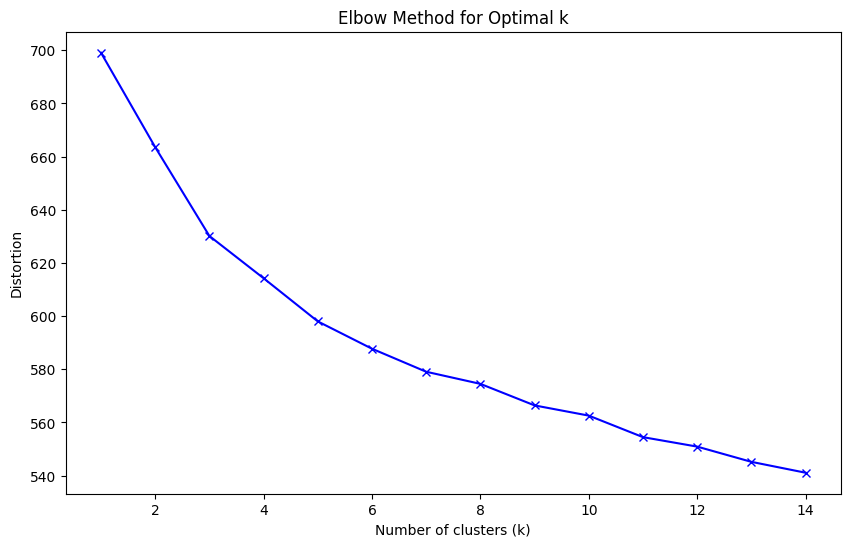

In [123]:
# with the distortions, plot the elbow graph
plt.figure(figsize=(10, 6))
plt.plot(K, distortions, 'bx-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Distortion')
plt.title('Elbow Method for Optimal k')
plt.show()

In [ ]:
# Clustering (choose n = 10, elbow graph does not say much)
n_clusters = 10
kmeans = KMeans(n_clusters=n_clusters, random_state=123)
labels = kmeans.fit_predict(genre_embeddings)

/Users/nselcheung/opt/anaconda3/envs/data_literacy/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/nselcheung/opt/anaconda3/envs/data_literacy/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/nselcheung/opt/anaconda3/envs/data_literacy/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


In [125]:
genre_description_df["cluster"] = labels

In [126]:
genre_description_df

,genre,description,has_description,cluster
0,stitchpunk,9 is a 2009 animated post-apocalyptic science ...,1,6
1,glam rock,Glam rock (also known as glitter rock) is a su...,1,0
2,television film,A television film (also known as television mo...,1,8
3,electronicore,Electronicore (also known as synthcore or tran...,1,0
4,nunsploitation,Nunsploitation is a subgenre of exploitation f...,1,5
...,...,...,...,...
860,fantasy anime and manga,fantasy anime and manga,0,1
861,outlaw biker film,The outlaw biker film is a film genre that por...,1,5
862,world music,"""World music"" is an English phrase for styles ...",1,7
863,slice of life,Slice of life is a depiction of mundane experi...,1,9


In [140]:
genre_description_df[genre_description_df.cluster==9].genre.unique()

array(['unreliable narrator', 'anthology', 'self-help',
       'dystopian fiction', 'Christian fiction', 'apocalyptic film',
       'adventure', 'coming-of-age fiction', 'thriller play',
       'tactical role-playing game', 'reportage', 'medieval fantasy',
       'fantasy film', 'biopunk', 'caper story',
       'psychological thriller film', 'heroic fantasy',
       'romantic drama fiction', 'thriller film', 'mental health',
       'contemporary fantasy', 'post-apocalyptic film',
       'historical fiction', 'political thriller', 'psychological drama',
       'financial thriller', 'visual novel', 'essay film',
       'supernatural thriller', 'robbery', 'alternate history',
       'crime thriller', 'white savior film', 'soul', 'technofantasy',
       'folklore', 'steampunk', 'narrative poetry', 'fairy tale',
       'social science fiction', 'romantic fantasy', 'crossover fiction',
       'adaptation', 'historical fantasy', 'mystery fiction',
       'speculative fiction', 'post-apocalypt

In [ ]:
genre_mapping = {
    0: "meta/emo/punk music",
    1: "anime",
    2: "romance",
    3: "horror",
    4: "comedy",
    5: "",
    6: "",
    7: "music",
    8: "science fiction",
    9: "metal"
}